Load cleaned data to train LSTM model

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/df.csv')

In [ ]:
df.head()

,clean_comment,category
0,family mormon try explain stare puzzled time...,1
1,buddhism lot compatible christianity especiall...,1
2,seriously don thing win complex explain normal...,0
3,benefit want read live buddha live christ thic...,1
4,sit watch simpson episode lisa buddhist simpso...,0


In [ ]:
df.shape

(24107, 2)

In [ ]:
df['clean_comment'] = df['clean_comment'].astype(str)

In [ ]:
max_features = 3000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['clean_comment'].values)

In [ ]:
#tokenizer.word_counts
#tokenizer.word_index

In [ ]:
df_train, df_val = train_test_split(df, test_size=0.3)

In [ ]:
X_train = tokenizer.texts_to_sequences(df_train['clean_comment'].values)
X_train = pad_sequences(X_train,maxlen)
X_val = tokenizer.texts_to_sequences(df_val['clean_comment'].values)
X_val = pad_sequences(X_val,maxlen)

In [ ]:
Y_train = df_train['category'].values
Y_val = df_val['category'].values

In [ ]:
X_train

array([[   0,    0,    0, ..., 1850, 1209, 1638],
       [   0,    0,    0, ...,  130, 2218,   10],
       [   0,    0,    0, ...,    0,  552,  815],
       ...,
       [   0,    0,    0, ...,  213,   95,   75],
       [   0,    0,    0, ...,  198,   31,  908],
       [   0,    0,    0, ...,    0,   42, 1170]], dtype=int32)

In [ ]:
[X_train.shape,X_val.shape]

[(16874, 80), (7233, 80)]

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, 128))
model_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
tf.keras.callbacks.EarlyStopping

keras.callbacks.EarlyStopping

In [ ]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print('Train...')
model_lstm.fit(X_train, Y_train, batch_size=batch_size, epochs=15, validation_data=(X_val, Y_val), callbacks=[early_stop])

Train...
Epoch 1/15
528/528 [==============================] - 184s 342ms/step - loss: 0.4986 - accuracy: 0.7597 - val_loss: 0.4145 - val_accuracy: 0.8157
Epoch 2/15
528/528 [==============================] - 158s 299ms/step - loss: 0.3471 - accuracy: 0.8521 - val_loss: 0.4131 - val_accuracy: 0.8175
Epoch 3/15
528/528 [==============================] - 153s 290ms/step - loss: 0.2967 - accuracy: 0.8787 - val_loss: 0.4354 - val_accuracy: 0.8204
Epoch 4/15
528/528 [==============================] - 154s 292ms/step - loss: 0.2544 - accuracy: 0.8993 - val_loss: 0.4079 - val_accuracy: 0.8241
Epoch 5/15
528/528 [==============================] - 152s 288ms/step - loss: 0.2132 - accuracy: 0.9164 - val_loss: 0.4595 - val_accuracy: 0.8163
Epoch 6/15
528/528 [==============================] - 153s 290ms/step - loss: 0.1823 - accuracy: 0.9283 - val_loss: 0.5353 - val_accuracy: 0.8122
Epoch 7/15
528/528 [==============================] - 153s 290ms/step - loss: 0.1446 - accuracy: 0.9418 - val_loss:

In [ ]:
score_lstm, acc_lstm = model_lstm.evaluate(X_val, Y_val,
                            batch_size=batch_size)

227/227 [==============================] - 6s 26ms/step - loss: 0.7736 - accuracy: 0.8040


In [ ]:
print('Test score:', score_lstm)
print('Test accuracy:', acc_lstm)

Test score: 0.7735534310340881
Test accuracy: 0.8039541244506836


In [ ]:
predict = model_lstm.predict(X_val)

227/227 [==============================] - 6s 25ms/step


In [ ]:
Ynew = (predict > 0.5).astype("int32")

In [ ]:
df_val['predict'] = Ynew

In [ ]:
df_val.head()

,clean_comment,category,predict
6169,heartbreake picture hillary group child hold a...,1,1
18156,tax rebate upto lakh,1,0
22365,party want alliance congress deal work kejriwa...,1,1
5777,state bird punjab northern goshawk state rapto...,1,1
21422,venezuela nationalise private sector company o...,1,1


In [ ]:
true_labels = np.array(df_val['category'])
predicted_labels = np.array(df_val['predict'])
cm = confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      2466
           1       0.85      0.86      0.85      4767

    accuracy                           0.80      7233
   macro avg       0.78      0.78      0.78      7233
weighted avg       0.80      0.80      0.80      7233



Text(51.0, 0.5, 'Predicted label')

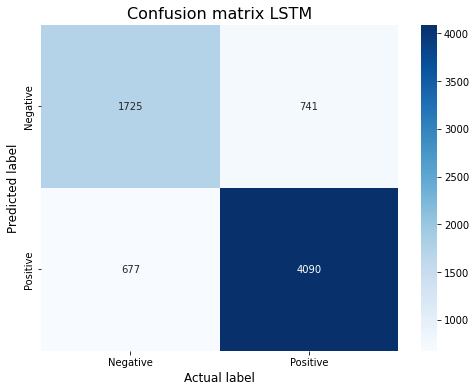

In [ ]:
# plot confusion matrix
sentiment_classes = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix LSTM', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)

In [ ]:
df_val['correct'] = df_val.apply(lambda x: 1 if x['category'] == x['predict'] else 0, axis=1)

In [ ]:
acc_lstm = df_val['correct'].sum()/df_val['correct'].count()
print(acc_lstm)

0.8027098022950366


In [ ]:
df_fault = df_val[df_val['correct']==0]

In [ ]:
df_fault.head()

,clean_comment,category,predict,correct
14235,come,0,1,0
7771,year year year year year year year year year...,0,1,0
8833,today rally organize goregaon mumbai bjp vhp a...,0,1,0
21556,fuck popular fuck major policy decision sort...,1,0,0
21312,man link look remind goro akechi persona leve...,1,0,0


In [ ]:
df_fault.shape

(1427, 4)

In [ ]:
max_features = 3000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_fault['clean_comment'].values)

In [ ]:

"""
word_counts = tokenizer.word_counts
print(word_counts)
#tokenizer.word_index
"""

'\nword_counts = tokenizer.word_counts\nprint(word_counts)\n#tokenizer.word_index\n'

Predict with textblob and Vader metholds

In [ ]:
df_train1, df_val1 = train_test_split(df, test_size=0.3)

In [ ]:
df_val1.head()

,clean_comment,category
15373,wrong vote retard lmao,0
9967,wait gdp come exact headline apart slowdown su...,1
8832,hope build damn temple asshole live jerk for...,1
7632,good point long time,1
9293,religion fine dandy rule not fucking kill peop...,0


In [ ]:
def get_sentiment_score(text):
    try:
        sid = SentimentIntensityAnalyzer()
        #print(f'SID object: {sid}')
        #print(f'Text input: {text}')
        #print(f'Sentiment scores: {sid.polarity_scores(str(text))}')
        return sid.polarity_scores(str(text))['compound']
    except Exception as e:
        #print(f'Error: {e}')
        return 0.0

In [ ]:
df_val1['polarity'] = df_val1['clean_comment'].apply(lambda x: TextBlob(str(x)).sentiment[0])
df_val1['polarity_v'] = df_val1['clean_comment'].apply(get_sentiment_score)
df_val1['sentiment'] = df_val1['polarity'].apply(lambda x: 1 if x>=0 else 0)
df_val1['sentiment_v'] = df_val1['polarity_v'].apply(lambda x: 1 if x>=0 else 0)
df_val1['textblob'] = df_val1.apply(lambda x: 1 if x['category'] == x['sentiment'] else 0, axis=1)
df_val1['vader'] = df_val1.apply(lambda x: 1 if x['category'] == x['sentiment_v'] else 0, axis=1)


In [ ]:
acc_textblob = df_val1['textblob'].sum()/df_val1['textblob'].count()
print(acc_textblob)
acc_vader = df_val1['vader'].sum()/df_val1['vader'].count()
print(acc_vader)

0.8722521775197014
0.7310935987833541


In [ ]:
df_val1.head()

,clean_comment,category,polarity,polarity_v,sentiment,sentiment_v,textblob,vader
15373,wrong vote retard lmao,0,-0.266667,-0.3818,0,0,1,1
9967,wait gdp come exact headline apart slowdown su...,1,0.035714,0.5994,1,1,1,1
8832,hope build damn temple asshole live jerk for...,1,0.136364,0.3182,1,1,1,1
7632,good point long time,1,0.325000,0.4404,1,1,1,1
9293,religion fine dandy rule not fucking kill peop...,0,0.358333,0.6961,1,1,0,0


In [ ]:
true_labels = np.array(df_val1['category'])
predicted_labels = np.array(df_val1['sentiment'])
cm = confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      2465
           1       0.91      0.90      0.90      4768

    accuracy                           0.87      7233
   macro avg       0.86      0.86      0.86      7233
weighted avg       0.87      0.87      0.87      7233



Text(51.0, 0.5, 'Predicted label')

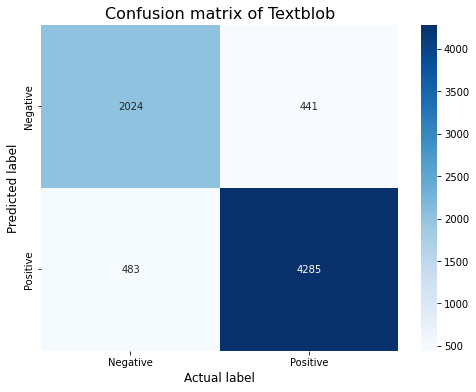

In [ ]:
# plot confusion matrix
sentiment_classes = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix of Textblob', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)

In [ ]:
true_labels = np.array(df_val1['category'])
predicted_labels = np.array(df_val1['sentiment_v'])
cm = confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.60      0.65      0.62      2465
           1       0.81      0.77      0.79      4768

    accuracy                           0.73      7233
   macro avg       0.70      0.71      0.71      7233
weighted avg       0.74      0.73      0.73      7233



Text(51.0, 0.5, 'Predicted label')

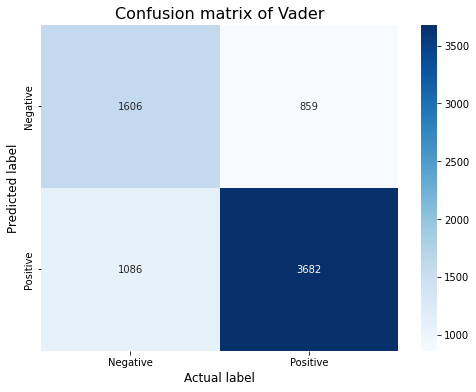

In [ ]:
# plot confusion matrix
sentiment_classes = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix of Vader', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
comment = pd.read_csv('/content/drive/MyDrive/comment_bert.csv')

In [ ]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Additional_Repeat_12,[],t3_rsrfa3,None,2,Even when I work salary I don’t answer calls d...,False,rsrfa3,1
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,X-Bones_21,[],t3_rtaumo,38623883497,3,I second this. When I sorted for UPS I rarely...,False,rtaumo,1
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,CEO \n\nUsless fucks just sit piss arsing abou...,False,rtaumo,0
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,[deleted],NaN,t3_rtaumo,None,1,Accounting,False,rtaumo,1
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,NaN,PristineAd9800,[],t3_rsp1vx,None,2,I’d work and see what happens. He didn’t cuz y...,False,rsp1vx,0


In [ ]:
comment.shape

(173867, 18)

In [ ]:
#Data cleaning;
comment['body1'] = comment['body'].astype(str)
comment['body1'] = comment['body1'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))
comment['body1'] = comment['body1'].apply(lambda x: x.lower())
comment['body1'] = comment['body1'].apply((lambda x: re.sub('[^\w\s]','',x)))

In [ ]:
comment.to_csv('/content/drive/MyDrive/comment_bert_cleaned.csv', index=False)

In [ ]:
max_features = 3000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(comment['body1'].values)

In [ ]:
X_val = tokenizer.texts_to_sequences(comment['body1'].values)
X_val = pad_sequences(X_val,maxlen)

In [ ]:
X_val.shape

(173867, 80)

In [ ]:
predict = model_lstm.predict(X_val)

5434/5434 [==============================] - 129s 24ms/step


In [ ]:
Ynew = (predict > 0.5).astype("int32")

In [ ]:
comment['predictions_lstm'] = Ynew

In [ ]:
comment['polarity'] = comment['body1'].apply(lambda x: TextBlob(str(x)).sentiment[0])
comment['polarity_v'] = comment['body1'].apply(get_sentiment_score)
comment['predictions_textblob'] = comment['polarity'].apply(lambda x: 1 if x>=0 else 0)
comment['predictions_vader'] = comment['polarity_v'].apply(lambda x: 1 if x>=0 else 0)



In [ ]:
comment.to_csv('/content/drive/MyDrive/comment_b_t_v_cleaned.csv', index=False)

In [ ]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,predictions_bert,predictions_textblob,predictions_vader,predictions_lstm
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,NaN,Additional_Repeat_12,[],t3_rsrfa3,None,2,Even when I work salary I don’t answer calls d...,False,rsrfa3,1,1,1,1
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,X-Bones_21,[],t3_rtaumo,38623883497,3,I second this. When I sorted for UPS I rarely...,False,rtaumo,1,1,0,0
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,CEO \n\nUsless fucks just sit piss arsing abou...,False,rtaumo,0,0,0,1
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,NaN,[deleted],NaN,t3_rtaumo,None,1,Accounting,False,rtaumo,1,1,1,1
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,NaN,PristineAd9800,[],t3_rsp1vx,None,2,I’d work and see what happens. He didn’t cuz y...,False,rsp1vx,0,1,1,1


In [ ]:
comment.shape

(173867, 16)

In [ ]:
comment = comment.drop(['body1', 'polarity', 'polarity_v'], axis=1)

In [ ]:
comment.to_csv('/content/drive/MyDrive/comment_all_model.csv', index=False)